In [1]:
!apt-get update && apt-get install libsm6 libxext6  -y
!apt-get install libgl1-mesa-glx -y
!pip install natsort
!pip install ipython-autotime
!pip install opencv-python
!pip install seaborn
!pip install scikit-learn

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2469 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1092 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1917 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [44.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2187 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [927 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-upda

# IMPORT PACKAGES

In [2]:
import os
import shutil
import numpy as np
import cv2
import zipfile
from PIL import Image
import tensorflow as tf
import pandas as pd
import pathlib
import natsort
import sys

import matplotlib.pyplot as plt
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
%load_ext autotime

# print(tf.__version__)
# seed = 42
# tf.random.set_seed(seed)
# np.random.seed(seed)

2024-06-18 09:30:11.046854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 09:30:11.046909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 09:30:11.048166: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 09:30:11.056599: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


time: 110 µs (started: 2024-06-18 09:30:15 +00:00)


In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     # Enable GPU memory growth (optional)
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
#     # Set mixed precision policy
#     policy = tf.keras.mixed_precision.Policy('mixed_float32')
#     tf.keras.mixed_precision.set_global_policy(policy)

# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# print("TensorFlow GPU device: ", tf.test.gpu_device_name())
# print("All devices: ", tf.config.list_physical_devices())

time: 289 µs (started: 2024-06-18 09:30:15 +00:00)


In [4]:
EPOCHS = 200
ETA = 0.001
WEIGHT_DECAY = 6e-8
IMAGE_SHAPE = (1024, 1024, 3)
MASK_SHAPE = (1024, 1024, 3)
model_path = '/notebooks/retouch_to_raw/saved_model'
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 1024
IMG_HEIGHT = 1024
OUTPUT_CHANNELS = 3

time: 462 µs (started: 2024-06-18 09:30:15 +00:00)


In [5]:
# import os

# directory = 'path/to/your/directory'
# file_count = 0

# for filename in os.listdir(directory):
#     filepath = os.path.join(directory, filename)
#     if os.path.isfile(filepath):
#         file_count += 1

# print(f"Total files in directory '{directory}': {file_count}")

time: 193 µs (started: 2024-06-18 09:30:15 +00:00)


# READ DATASET (IMAGES, MASKS)

In [6]:
PATH = pathlib.Path('/notebooks/retouch_to_raw/dataset')
list(PATH.parent.iterdir())

[PosixPath('/notebooks/retouch_to_raw/dataset'),
 PosixPath('/notebooks/retouch_to_raw/tested_images'),
 PosixPath('/notebooks/retouch_to_raw/CRHD-3K_gt.zip'),
 PosixPath('/notebooks/retouch_to_raw/CRHD-3K_src.zip'),
 PosixPath('/notebooks/retouch_to_raw/raw_image'),
 PosixPath('/notebooks/retouch_to_raw/retouch_images'),
 PosixPath('/notebooks/retouch_to_raw/.ipynb_checkpoints'),
 PosixPath('/notebooks/retouch_to_raw/__MACOSX')]

time: 3.48 ms (started: 2024-06-18 09:30:15 +00:00)


(1024, 1024, 3)


2024-06-18 09:30:15.187059: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-18 09:30:15.203866: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-18 09:30:15.204064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

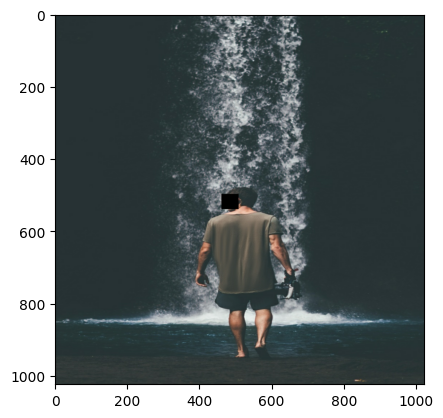

time: 639 ms (started: 2024-06-18 09:30:15 +00:00)


In [7]:
sample_image = tf.io.read_file(str(PATH / 'train/re/image_0.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)
plt.figure()
plt.imshow(sample_image)

In [8]:
def load(image_file):
    print(image_file)
    parts = tf.strings.split(image_file, '/')
    
    parent = parts[:-2]
    subdirectory = parts[-2]  
    filename = parts[-1]

    # Convert tensors to list for joining paths
    parent_parts = tf.unstack(parent)
    
    # Construct input and raw image paths
    input_path_parts = parent_parts + [subdirectory, 're', filename]
    raw_path_parts = parent_parts + [subdirectory, 'raw', filename]

    input_path = tf.strings.join(input_path_parts, separator='/')
    raw_path = tf.strings.join(raw_path_parts, separator='/')
    
    print(input_path)

    # Get scalar string values from tensors
    input_path = input_path.numpy().decode('utf-8')
    raw_path = raw_path.numpy().decode('utf-8')

    # Read and decode images
    input_image = tf.io.read_file(input_path)
    input_image = tf.image.decode_jpeg(input_image, channels=3)
    raw_image = tf.io.read_file(raw_path)
    raw_image = tf.image.decode_jpeg(raw_image, channels=3)

    # Cast images to float32
    input_image = tf.cast(input_image, tf.float32)
    raw_image = tf.cast(raw_image, tf.float32)

    return input_image, raw_image

# Example usage
image_file = str(PATH / 'train/image_0.jpg')
inp, re = load(image_file)

/notebooks/retouch_to_raw/dataset/train/image_0.jpg
tf.Tensor(b'/notebooks/retouch_to_raw/dataset/train/re/image_0.jpg', shape=(), dtype=string)
time: 69 ms (started: 2024-06-18 09:30:15 +00:00)


/notebooks/retouch_to_raw/dataset/train/image_0.jpg
tf.Tensor(b'/notebooks/retouch_to_raw/dataset/train/re/image_0.jpg', shape=(), dtype=string)


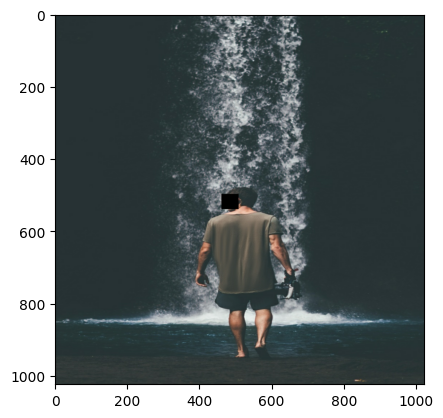

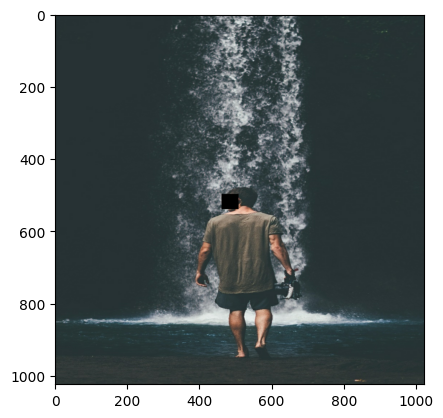

time: 686 ms (started: 2024-06-18 09:30:15 +00:00)


In [9]:
image_file = str(PATH / 'train/image_0.jpg')
inp, re = load(image_file)
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [10]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image


def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]


# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 1152, 1152)
    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)
    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

time: 2.54 ms (started: 2024-06-18 09:30:16 +00:00)


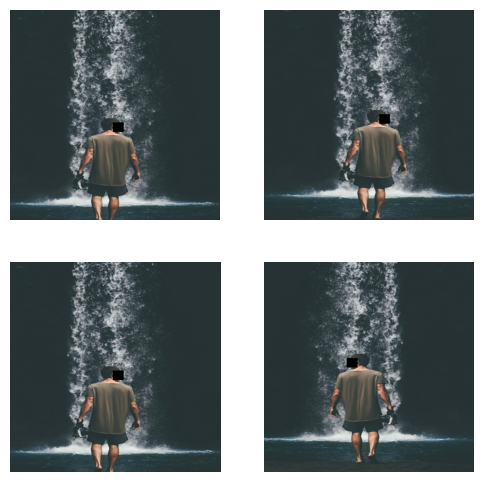

time: 990 ms (started: 2024-06-18 09:30:16 +00:00)


In [11]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis("off")
plt.show()

In [12]:
PATH = pathlib.Path('/notebooks/retouch_to_raw/dataset')

def load(input_image, output_image):
    input_image = tf.io.read_file(input_image)
    input_image = tf.image.decode_jpeg(input_image, channels=3)
    output_image = tf.io.read_file(output_image)
    output_image = tf.image.decode_jpeg(output_image, channels=3)
    input_image = tf.cast(input_image, tf.float32)
    output_image = tf.cast(output_image, tf.float32)

    return input_image, output_image

def load_image_train(input_image, output_image):
    input_image, real_image = load(input_image, output_image)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(input_image, output_image):
    input_image, real_image = load(input_image, output_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

time: 703 µs (started: 2024-06-18 09:30:17 +00:00)


In [13]:
# # Load paths for train dataset
# input_train_paths = tf.data.Dataset.list_files(str(PATH / 'initial/re/*.jpg'), shuffle=False)
# output_train_paths = tf.data.Dataset.list_files(str(PATH / 'initial/raw/*.jpg'), shuffle=False)
# train_dataset = tf.data.Dataset.zip((input_train_paths, output_train_paths))

# # Shuffle and split train_dataset into train, validation, and test datasets
# # Count the total number of samples in train_dataset
# num_samples = sum(1 for _ in train_dataset)

# # Define the sizes for train, val, and test sets
# train_size = int(0.97 * num_samples)  # 70% of data for training
# val_size = int(0.02 * num_samples)  # 15% of data for validation
# test_size = num_samples - train_size - val_size  # Remaining data for testing

# # Shuffle and split the dataset
# train_dataset = train_dataset.shuffle(BUFFER_SIZE)
# train_dataset = train_dataset.take(train_size)
# remaining_dataset = train_dataset.skip(train_size)
# val_dataset = remaining_dataset.take(val_size)
# test_dataset = remaining_dataset.skip(val_size)

# # Define functions to load and preprocess data
# def load_and_preprocess_train(input_path, output_path):
#     input_image, output_image = tf.py_function(load_image_train, [input_path, output_path], [tf.float32, tf.float32])
#     return input_image, output_image

# def load_and_preprocess_test(input_path, output_path):
#     input_image, output_image = tf.py_function(load_image_test, [input_path, output_path], [tf.float32, tf.float32])
#     return input_image, output_image

# # Map functions to datasets
# train_dataset = train_dataset.map(load_and_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
# test_dataset = test_dataset.map(load_and_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
# val_dataset = val_dataset.map(load_and_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

# # Batch datasets
# val_dataset = val_dataset.shuffle(BUFFER_SIZE)
# test_dataset = test_dataset.shuffle(BUFFER_SIZE)

# train_dataset = train_dataset.batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)
# val_dataset = val_dataset.batch(BATCH_SIZE)

time: 948 µs (started: 2024-06-18 09:30:17 +00:00)


In [19]:
input_paths = tf.data.Dataset.list_files(str(PATH / 'initial/re/*.jpg'), shuffle=False)
output_paths = tf.data.Dataset.list_files(str(PATH / 'initial/raw/*.jpg'), shuffle=False)
dataset = tf.data.Dataset.zip((input_paths, output_paths))
data_list = list(dataset.as_numpy_iterator())

# Split the dataset into training, validation, and test sets
val_size = 0.02  # Example: 10% for validation
test_size = 0.01  # Example: 10% for test
total_size = len(data_list)
val_split = int(total_size * val_size)
test_split = int(total_size * (val_size + test_size))

train_data = data_list[:val_split]
val_data = data_list[val_split:test_split]
test_data = data_list[test_split:]

train_data = tf.data.Dataset.from_tensor_slices(train_data)
val_data = tf.data.Dataset.from_tensor_slices(val_data)
test_data = tf.data.Dataset.from_tensor_slices(test_data)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_data = val_data.batch(BATCH_SIZE)
test_data = test_data.batch(BATCH_SIZE)

time: 611 ms (started: 2024-06-18 09:46:05 +00:00)


In [21]:
print(type(val_data))
dataset_length = val_data.reduce(0, lambda x, _: x + 1).numpy()
print(dataset_length)

<class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'>
time: 285 µs (started: 2024-06-18 09:46:05 +00:00)


In [24]:
input_train = tf.data.Dataset.list_files(str(PATH / 'train/re/*.jpg'), shuffle=False)
output_train = tf.data.Dataset.list_files(str(PATH / 'train/raw/*.jpg'), shuffle=False)
train_dataset = tf.data.Dataset.zip((input_train, output_train))

def load_and_preprocess_train(input_path, output_path):
    input_image, output_image = tf.py_function(load_image_train, [input_path, output_path], [tf.float32, tf.float32])
    return input_image, output_image

train_dataset = train_dataset.map(load_and_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(BUFFER_SIZE)

input_test = tf.data.Dataset.list_files(str(PATH / 'test/re/*.jpg'), shuffle=False)
output_test = tf.data.Dataset.list_files(str(PATH / 'test/raw/*.jpg'), shuffle=False)
test_dataset = tf.data.Dataset.zip((input_test, output_test))

def load_and_preprocess_test(input_path, output_path):
    input_image, output_image = tf.py_function(load_image_test, [input_path, output_path], [tf.float32, tf.float32])
    return input_image, output_image

test_dataset = test_dataset.map(load_and_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

input_val = tf.data.Dataset.list_files(str(PATH / 'val/re/*.jpg'), shuffle=False)
output_val = tf.data.Dataset.list_files(str(PATH / 'val/raw/*.jpg'), shuffle=False)
val_dataset = tf.data.Dataset.zip((input_val, output_val))
def load_and_preprocess_val(input_path, output_path):
    input_image, output_image = tf.py_function(load_image_test, [input_path, output_path], [tf.float32, tf.float32])
    return input_image, output_image

val_dataset = val_dataset.map(load_and_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

time: 259 ms (started: 2024-06-18 09:52:11 +00:00)


181
time: 2.78 s (started: 2024-06-18 09:52:27 +00:00)


In [15]:
# !apt-get install graphviz -y
# !pip install pydot

time: 185 µs (started: 2024-06-18 08:53:58 +00:00)


In [16]:
def res_block_initial(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer for first layer

    In the residual unet the first residual block does not contain an
    initial batch normalization and activation so we create this separate
    block for it.

    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]

    x1 = tf.keras.layers.Conv2D(
        filters=num_filters[0],
        kernel_size=kernel_size,
        strides=strides[0],
        padding="same",
        name=name + "_1",
    )(x)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation("relu")(x1)
    x1 = tf.keras.layers.Conv2D(
        filters=num_filters[1],
        kernel_size=kernel_size,
        strides=strides[1],
        padding="same",
        name=name + "_2",
    )(x1)

    x = tf.keras.layers.Conv2D(
        filters=num_filters[-1],
        kernel_size=1,
        strides=1,
        padding="same",
        name=name + "_shortcut",
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x1 = tf.keras.layers.Add()([x, x1])

    return x1


def res_block(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer

    Consists of batch norm and relu, folowed by conv, batch norm and relu and
    final convolution. The input is then put through


    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]

    x1 = tf.keras.layers.BatchNormalization()(x)
    x1 = tf.keras.layers.Activation("relu")(x1)
    x1 = tf.keras.layers.Conv2D(
        filters=num_filters[0],
        kernel_size=kernel_size,
        strides=strides[0],
        padding="same",
        name=name + "_1",
    )(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation("relu")(x1)
    x1 = tf.keras.layers.Conv2D(
        filters=num_filters[1],
        kernel_size=kernel_size,
        strides=strides[1],
        padding="same",
        name=name + "_2",
    )(x1)

    x = tf.keras.layers.Conv2D(
        filters=num_filters[-1],
        kernel_size=1,
        strides=strides[0],
        padding="same",
        name=name + "_shortcut",
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x1 = tf.keras.layers.Add()([x, x1])

    return x1


def upsample(x, target_size):
    """ "Upsampling function, upsamples the feature map

    Deep Residual Unet paper does not describe the upsampling function
    in detail. Original Unet uses a transpose convolution that downsamples
    the number of feature maps. In order to restrict the number of
    parameters here we use a bilinear resampling layer. This results in
    the concatentation layer concatenting feature maps with n and n/2
    features as opposed to n/2  and n/2 in the original unet.

    Args:
        x: tensor, feature map
        target_size: size to resize feature map to
    Returns:
        x_resized: tensor, upsampled feature map
    """

    x_resized = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, target_size))(x)

    return x_resized


def encoder(x, num_filters, kernel_size):
    """Unet encoder

    Args:
        x: tensor, output from previous layer
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        encoder_output: list, output from all encoder layers
    """

    x = res_block_initial(
        x, [num_filters[0]], kernel_size, strides=[1, 1], name="layer1"
    )

    encoder_output = [x]
    for i in range(1, len(num_filters)):
        layer = "encoder_layer" + str(i)
        x = res_block(x, [num_filters[i]], kernel_size, strides=[2, 1], name=layer)
        encoder_output.append(x)

    return encoder_output


def decoder(x, encoder_output, num_filters, kernel_size):
    """Unet decoder

    Args:
        x: tensor, output from previous layer
        encoder_output: list, output from all previous encoder layers
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        x: tensor, output from last layer of decoder
    """

    for i in range(1, len(num_filters) + 1):
        layer = "decoder_layer" + str(i)
        target_size = encoder_output[-i].shape[1:3]
        x = upsample(x, target_size)
        print("decoder=", x.shape, encoder_output[-i].shape)
        x = tf.keras.layers.Concatenate(axis=-1)([x, encoder_output[-i]])
        x = res_block(x, [num_filters[-i]], kernel_size, strides=[1, 1], name=layer)

    return x


def res_unet(input_size, num_filters, kernel_size, num_channels):
    """Residual Unet

    Function that generates a residual unet

    Args:
        input_size: int, dimension of the input image
        num_layers: int, number of layers in the encoder half, excludes bridge
        num_filters: list, number of filters for each encoder layer
        kernel_size: size of the kernel, applied to all convolutions
        num_channels: int, number of channels for the input image
        num_classes: int, number of output classes for the output
    Returns:
        model: tensorflow keras model for residual unet architecture
    """

    x = tf.keras.Input(shape=[input_size, input_size, num_channels])

    encoder_output = encoder(x, num_filters, kernel_size)

    # bridge layer, number of filters is double that of the last encoder layer
    bridge = res_block(
        encoder_output[-1],
        [num_filters[-1] * 2],
        kernel_size,
        strides=[2, 1],
        name="bridge",
    )

    print("encoder output:", encoder_output[-1].shape)
    decoder_output = decoder(bridge, encoder_output, num_filters, kernel_size)

    output = tf.keras.layers.Conv2DTranspose(
        3, kernel_size, strides=1, padding="same", name="output"
    )(decoder_output)

    model = tf.keras.Model(x, output)

    return model


time: 2.89 ms (started: 2024-06-18 08:53:58 +00:00)


In [17]:
# num_layers=6
# filters=64
# tf.keras.backend.clear_session()
# generator = res_unet(input_size=1024, num_filters=[filters*2**i for i in range(num_layers)], kernel_size=3, 
#                      num_channels=3)
# generator.summary()
# # tf.keras.utils.plot_model(generator, show_shapes=True)

time: 606 µs (started: 2024-06-18 08:53:58 +00:00)


In [18]:
def convolution(input, filters, padding, strides, kernel, activation, conv_type, name_prefix=''):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = input
    x = layers.Conv2D(filters, kernel_size=kernel, padding=padding, strides=strides, 
                      kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv1')(x)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn1')(x)
    x = layers.Activation(activation, name=f'{name_prefix}_activation1')(x)
    
    if conv_type == 'decoder':
        x = layers.Conv2D(filters, kernel_size=kernel, padding=padding, strides=strides, 
                          kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv2')(x)
        x = layers.BatchNormalization(name=f'{name_prefix}_bn2')(x)
        x = layers.Activation(activation, name=f'{name_prefix}_activation2')(x)
    return x

def encoder(input, filters, padding, strides, kernel, activation, name_prefix):
    x = convolution(input, filters, padding, strides, kernel, activation, 'encoder', name_prefix=name_prefix)
    down = layers.Conv2D(filters, kernel_size=kernel, padding=padding, strides=2, 
                      kernel_initializer=tf.random_normal_initializer(0., 0.02), use_bias=False, name=f'{name_prefix}_conv_down')(x)
    down = layers.BatchNormalization(name=f'{name_prefix}_bn_down')(down)
    down =  layers.Activation(activation, name=f'{name_prefix}_activation3')(down)
    return down, x

def decoder(input, filters, skip, padding, strides, kernel, activation, name_prefix, dropout=False):
    x = input
    x = layers.Conv2DTranspose(filters, padding=padding, kernel_size=kernel, strides=2,
                               kernel_initializer=tf.random_normal_initializer(0., 0.02), use_bias=False,
                               name=f'{name_prefix}_transpose')(x)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn_transpose')(x)
    
    if dropout:
        x = layers.Dropout(0.5, name=f'{name_prefix}_dropout')(x)
    
    x = layers.Concatenate(name=f'{name_prefix}_skip_connection')([x, skip])
    x = convolution(x, filters, padding, strides, kernel, activation, 'decoder', name_prefix=name_prefix)
    return x

time: 167 ms (started: 2024-06-18 08:53:58 +00:00)


In [19]:
def bottleneck(input, filters_bottleneck, strides, kernel, activation, depth=6, mode='cascade', name_prefix=''):
    dilated_layers = []
    x = input
    if mode == 'cascade':
        for i in range(depth):
            residual = x
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                               activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02), name=f'{name_prefix}_conv_{i+1}')(x)
            dilated_layers.append(x)
        x = layers.add(dilated_layers, name=f'{name_prefix}_dilated_layers')
        x = layers.GroupNormalization(groups=filters_bottleneck, name=f'{name_prefix}_gn')(x)
        return x
    
    elif mode == 'cascade_residual':
        for i in range(depth):
            residual = x  # Save the input for the residual connection
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                              activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
            dilated_layers.append(x)
            if i % 2 == 0:  # Add residual connection only on even convolutional layers
                # Add a 1x1 convolution to the residual connection to match shapes
                residual = layers.Conv2D(filters_bottleneck, kernel_size=1, strides=strides,
                                         padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(residual)
                residual = layers.GroupNormalization(groups=filters_bottleneck)(residual)
                # Add the residual connection
                x = layers.add([x, residual])
            
        cascade_layer = layers.add(dilated_layers)
        fusion = layers.add([cascade_layer, x])
        fusion = layers.GroupNormalization(groups=filters_bottleneck)(fusion)
        return fusion
    
    elif mode == 'cascade_residual_multidimension':
        for i in range(depth):
            residual = x 
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                               activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
            dilated_layers.append(x)
            residual = layers.Conv2D(filters_bottleneck, kernel_size=1, strides=strides,
                                     padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(residual)
            residual = layers.GroupNormalization(groups=filters_bottleneck)(residual)
            x = layers.add([x, residual])
            dilated_layers.append(x)
        fusion = layers.add(dilated_layers)
        fusion = layers.GroupNormalization(groups=filters_bottleneck)(fusion)
        return fusion
    
    elif mode == 'parallel':  # Like "Atrous Spatial Pyramid Pooling"
        for i in range(depth):
            dilated_layers.append(
                layers.Conv2D(filters_bottleneck, kernel_size=kernel,
                       activation=activation, padding='same', dilation_rate=2**i)(x)
            )
        parallel = layers.add(dilated_layers) 
        parallel = layers.GroupNormalization(groups=filters_bottleneck)(parallel)
        return parallel

time: 1.55 ms (started: 2024-06-18 08:53:58 +00:00)


In [20]:
def Generator(input, filter, padding, strides, kernel, model_weights, weights_path=''):
    x = input
    con1, skip1 = encoder(x, filter, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='encoder1')
    con2, skip2 = encoder(con1, filter*2, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='encoder2')
    con3, skip3 = encoder(con2, filter*4, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='encoder3')
    con4, skip4 = encoder(con3, filter*8, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='encoder4')
    con5, skip5 = encoder(con4, filter*16, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='encoder5')
    con6, skip6 = encoder(con5, filter*16, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='encoder6')
    con7, skip7 = encoder(con6, filter*16, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='encoder7')
    con8, skip8 = encoder(con7, filter*16, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='encoder8')
    con9, skip9 = encoder(con8, filter*16, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='encoder9')
    # con9, skip9 = encoder(con8, filter*16, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='encoder10')

    bottle = bottleneck(con9, filters_bottleneck=filter*2**4, strides=strides, kernel=kernel, 
                        activation=layers.LeakyReLU(), depth=5, mode='cascade', name_prefix='bottleneck')
    
    # deco1 = decoder(con9, filter*16, skip9, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), dropout=True, name_prefix='decoder1')
    deco1 = decoder(bottle, filter*16, skip9, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), dropout=True, name_prefix='decoder1')
    deco2 = decoder(deco1, filter*16, skip8, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), dropout=True, name_prefix='decoder2')
    deco3 = decoder(deco2, filter*16, skip7, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), dropout=True, name_prefix='decoder3')
    deco4 = decoder(deco3, filter*16, skip6, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='decoder4')
    deco5 = decoder(deco4, filter*16, skip5, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='decoder5')
    deco6 = decoder(deco5, filter*8, skip4, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='decoder6')
    deco7 = decoder(deco6, filter*4, skip3, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='decoder7')
    deco8 = decoder(deco7, filter*2, skip2, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='decoder8')
    deco9 = decoder(deco8, filter, skip1, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(), name_prefix='decoder9')
    
    initializer = tf.random_normal_initializer(0., 0.02)
    output = layers.Conv2DTranspose(3, kernel_size=kernel, strides=strides, padding=padding, 
                                    kernel_initializer=initializer, activation='tanh', 
                                    name='generator_output_layer')(deco9)
    generator = models.Model(inputs=input, outputs=output, name='generator')
    
    if model_weights is not None:
        generator.load_weights(weights_path)
    generator.summary()
    return generator

time: 1.64 ms (started: 2024-06-18 08:53:58 +00:00)


In [21]:
tf.keras.backend.clear_session()
generator = Generator(input=layers.Input(shape = IMAGE_SHAPE), filter=64, padding='same', kernel=3, strides=1, 
                            model_weights=None, 
                            weights_path="")
# tf.keras.utils.plot_model(generator, show_shapes=True)

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 encoder1_conv1 (Conv2D)     (None, 1024, 1024, 64)       1728      ['input_1[0][0]']             
                                                                                                  
 encoder1_bn1 (BatchNormali  (None, 1024, 1024, 64)       256       ['encoder1_conv1[0][0]']      
 zation)                                                                                          
                                                                                                  
 encoder1_activation1 (Acti  (None, 1024, 1024, 64)       0         ['encoder1_bn1[0][0]']

In [22]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    if apply_batchnorm:
        result.add(layers.GroupNormalization(groups=filters))
    result.add(tf.keras.layers.LeakyReLU())
    return result


down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)

2024-06-18 08:53:59.354017: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


(1, 512, 512, 3)
time: 802 ms (started: 2024-06-18 08:53:59 +00:00)


In [23]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 1024, 1024, 3)
time: 461 ms (started: 2024-06-18 08:54:00 +00:00)


In [24]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[1024, 1024, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  
        downsample(128, 4),  
        downsample(256, 4), 
        downsample(512, 4), 
        downsample(1024, 4),  
        downsample(1024, 4), 
        downsample(2048, 4),
        downsample(2048, 4), 
        downsample(2048, 4), 
        downsample(2048, 4), 
    ]

    up_stack = [
        upsample(2048, 4, apply_dropout=True),  
        upsample(2048, 4, apply_dropout=True),  
        upsample(2048, 4),  
        upsample(1024, 4),  
        upsample(1024, 4),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS,
        4,
        strides=2,
        padding="same",
        kernel_initializer=initializer,
        activation="tanh",
    )

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


time: 898 µs (started: 2024-06-18 08:54:00 +00:00)


In [25]:
# generator2 = Generator()
# generator2.summary()
# # tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

time: 644 µs (started: 2024-06-18 08:54:00 +00:00)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


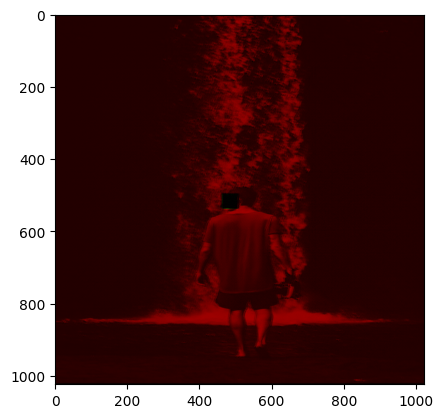

time: 19.8 s (started: 2024-06-18 08:54:00 +00:00)


In [26]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [27]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    ssim_l = ssim_loss(target, gen_output)
    total_gen_loss = gan_loss + (LAMBDA * l1_loss) + ssim_l
    return total_gen_loss, gan_loss, l1_loss, ssim_l

time: 731 µs (started: 2024-06-18 08:54:20 +00:00)


In [28]:
# LAMBDA = 100
# loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# def generator_loss(disc_generated_output, gen_output, target):
#     gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
#     l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
#     total_gen_loss = gan_loss + (LAMBDA * l1_loss)
#     return total_gen_loss, gan_loss, l1_loss

time: 250 µs (started: 2024-06-18 08:54:20 +00:00)


In [29]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.0, 0.02)

    inp = tf.keras.layers.Input(shape=[1024, 1024, 3], name="input_image")
    tar = tf.keras.layers.Input(shape=[1024, 1024, 3], name="target_image")
    x = tf.keras.layers.concatenate([inp, tar])  

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    down4 = downsample(512, 4)(down3)
    down5 = downsample(1024, 4)(down4)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down5)
    conv = tf.keras.layers.Conv2D(2048, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

time: 743 µs (started: 2024-06-18 08:54:20 +00:00)


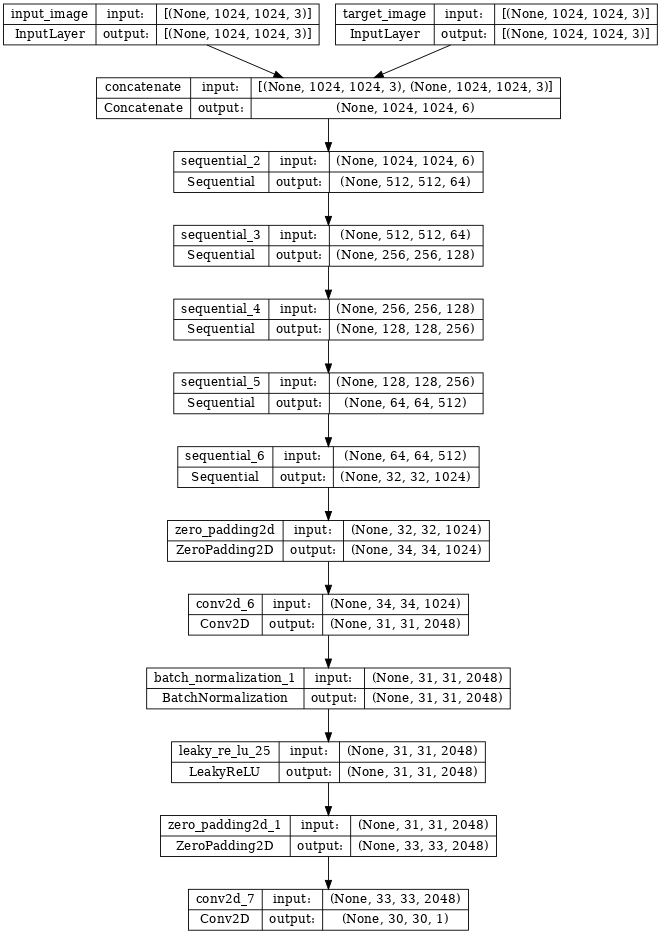

time: 413 ms (started: 2024-06-18 08:54:20 +00:00)


In [30]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

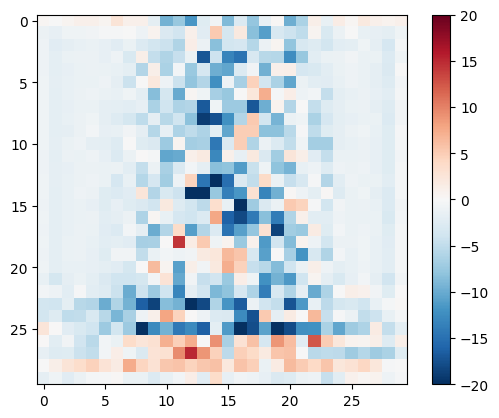

time: 1.4 s (started: 2024-06-18 08:54:20 +00:00)


In [31]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [32]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

time: 347 µs (started: 2024-06-18 08:54:22 +00:00)


In [33]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

time: 5.09 ms (started: 2024-06-18 08:54:22 +00:00)


In [ ]:
discrminator.compile(tf.keras.optimizers.Adam(2e-4, beta_1=0.5))

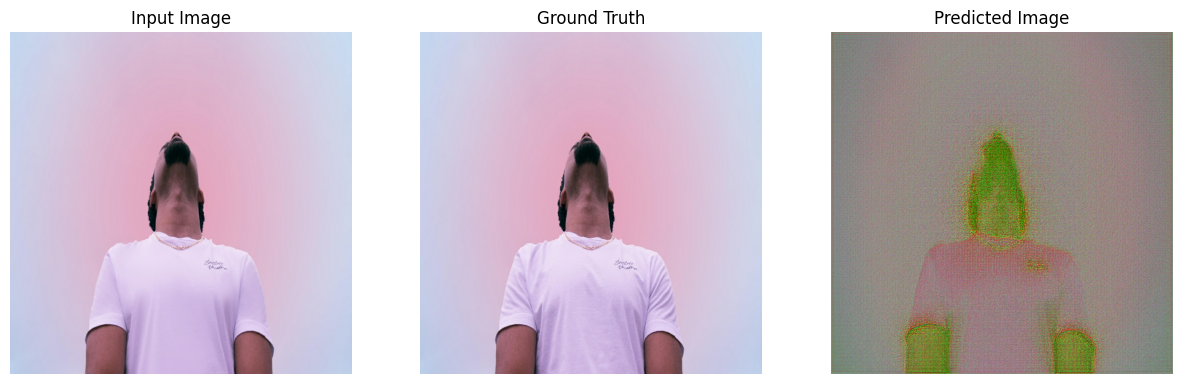

time: 3.11 s (started: 2024-06-18 08:54:22 +00:00)


In [34]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ["Input Image", "Ground Truth", "Predicted Image"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    plt.show()


for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [35]:
import datetime, time
from IPython import display

log_dir="logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

time: 3.89 ms (started: 2024-06-18 08:54:25 +00:00)


In [36]:
def compute_ssim(target, gen_output):
    target = tf.image.convert_image_dtype(target, tf.float32)
    gen_output = tf.image.convert_image_dtype(gen_output, tf.float32)
    return tf.image.ssim(target, gen_output, max_val=1.0)

def compute_psnr(target, gen_output):
    target = tf.image.convert_image_dtype(target, tf.float32)
    gen_output = tf.image.convert_image_dtype(gen_output, tf.float32)
    return tf.image.psnr(target, gen_output, max_val=1.0)

time: 452 µs (started: 2024-06-18 08:54:25 +00:00)


In [37]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss, gen_ssim_loss = generator_loss(disc_generated_output, gen_output, target)
        
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    ssim_value = tf.reduce_mean(compute_ssim(target, gen_output))
    psnr_value = tf.reduce_mean(compute_psnr(target, gen_output))

    with summary_writer.as_default():
        tf.summary.scalar("gen_total_loss", gen_total_loss, step=step // 1000)
        tf.summary.scalar("gen_gan_loss", gen_gan_loss, step=step // 1000)
        tf.summary.scalar("gen_l1_loss", gen_l1_loss, step=step // 1000)
        tf.summary.scalar("gen_ssim_loss", gen_ssim_loss, step=step // 1000)
        tf.summary.scalar("disc_loss", disc_loss, step=step // 1000)
        tf.summary.scalar("ssim", ssim_value, step=step // 1000)
        tf.summary.scalar("psnr", psnr_value, step=step // 1000)

time: 1.07 ms (started: 2024-06-18 08:54:25 +00:00)


In [38]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f"Time taken for 1000 steps: {time.time()-start:.2f} sec\n")

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step + 1) % 10 == 0:
            print(".", end="", flush=True)

        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        if (step + 1) % 1000 == 0:
            ssim_value = tf.reduce_mean(compute_ssim(target, generator(input_image, training=False)))
            psnr_value = tf.reduce_mean(compute_psnr(target, generator(input_image, training=False)))
            print(f"SSIM: {ssim_value.numpy():.4f}, PSNR: {psnr_value.numpy():.2f}")

time: 919 µs (started: 2024-06-18 08:54:25 +00:00)


In [39]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 2657), started 1:34:18 ago. (Use '!kill 2657' to kill it.)

time: 7.71 ms (started: 2024-06-18 08:54:25 +00:00)


Time taken for 1000 steps: 646.77 sec



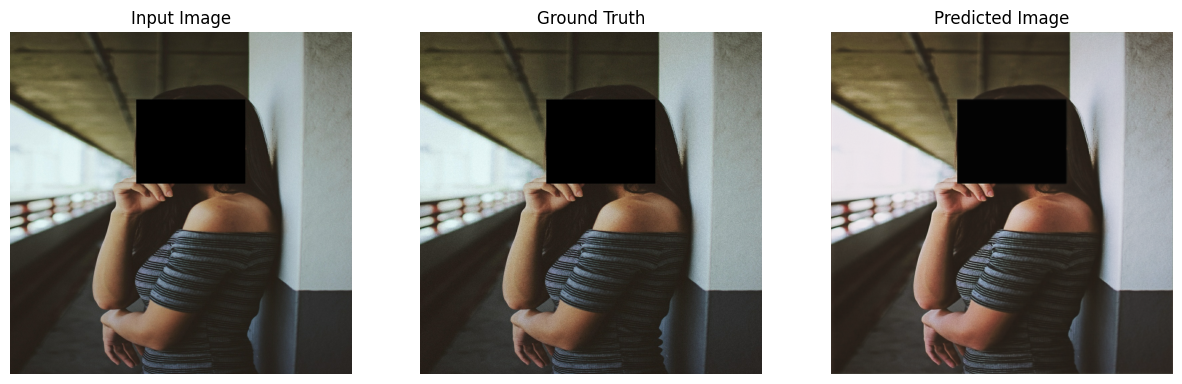

Step: 2k
..................................................................

In [ ]:
tf.keras.backend.clear_session()
fit(train_dataset, test_dataset, steps=8000)

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# Compress the logs
tar -czf logs.tar.gz logs/

# # # running tensorboard into google colab
# # Decompress the logs
# tar -xzf logs.tar.gz

# # Ensure TensorFlow and TensorBoard are installed
# pip install tensorflow tensorboard

# # In your new Jupyter notebook, launch TensorBoard
# %load_ext tensorboard
# %tensorboard --logdir logs/

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)